In [2]:
import os
import wget
import zipfile
from os.path import exists
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
bean_data_file= "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
base= "https://archive.ics.uci.edu/ml/machine-learning-databases/"
dataset_number= "00602"
if not exists(bean_data_file):
    filename="DryBeanDataset.zip"
    url = base + dataset_number+"/"+ filename
    wget.download(url)
    with zipfile.ZipFile(filename,"r") as zip_ref:
        zip_ref.extractall("./")
        os.remove(filename)

# bad model  

In [4]:
#read excel file
beans = pd.read_excel(bean_data_file)
#Labels are characters that needs to be converted to integer for sklearn
le= LabelEncoder()
beans["Class"]= le.fit_transform(beans["Class"])
# split data into classification target and feature
y= beans["Class"]
X = beans.drop("Class",axis=1)
#split of training data
X_train,X_rest1,y_train,y_rest1= train_test_split(X,y,train_size=10000,random_state=22)
#split of rest data in 2 groups

X_test,X_rest2,y_test,y_rest2= train_test_split(X_rest1,y_rest1, train_size=1000,random_state=42)

#split remaining in calibration data and "new" data for the conformal prediction step and for evaluating the conformal predictor

X_calib,X_new,y_calib,y_new= train_test_split(X_rest2,y_rest2, train_size=1000,random_state=33)

#fit the model
model= GaussianNB().fit(X_train,y_train)


In [5]:
#check accuracy
y_pred = model.predict(X_test)
print(f"Accuracy: {(y_pred== y_test).mean()}")
#crreate confusion matrix
cm= confusion_matrix(y_test,y_pred)
print(pd.DataFrame(cm,index= le.classes_,columns= le.classes_))

Accuracy: 0.743
          BARBUNYA  BOMBAY  CALI  DERMASON  HOROZ  SEKER  SIRA
BARBUNYA        36       0    53         0     13      0     2
BOMBAY           0      32     0         0      0      0     0
CALI            33       0    96         0      5      0     1
DERMASON         0       0     0       210      0     30    10
HOROZ            3       0     4         3    109      0    21
SEKER            2       0     0        24      0    114    18
SIRA             0       0     0         7     17     11   146


# first try: a naive approach to improve the model

In [6]:
predictions= model.predict_proba(X_calib)
#get for each instance the highest probability
high_prob_predictions= np.amax(predictions,axis=1)
#select only those where the probability is  over 95%
high_p_beans= np.where(high_prob_predictions>=0.95)
#let's count how often we hit the right label
its_a_match= (model.predict(X_calib)==y_calib)
coverage= np.mean(its_a_match.values[high_p_beans])
print(round(coverage,3))

0.92


# second attempt : conformal classification

0.92!= 0.95 wrong coverage.  instead of using the model probabilities we use the model prediction to build a measure of uncertainty:

s_i= 1- f(x_i)[y_i]

a notation that mean that we take 1 minus the probability of the true class. This is known as the non-conformity score and measure how unusual a suggested outcome is given the model output for x_i.
to decide which of the conformal predictions are "conformal", conformal prediction calculates a treshold based on the non-conformity scores of the calibration data in combination with the true labels.
the sequence is like this:
1. start with the data not used for training
2. Calculate the scores s_i
3. sort the scores from low (certain) to high (uncertain)
4. compute the threshold $\hat q$ where 95% of the s_i are smaller (= 95% quantile)


In [7]:
n = len(X_calib)
#get the probability predictions
predictions= model.predict_proba(X_calib)
#we only need the probability for the true class
prob_true_class= predictions[np.arange(n),y_calib]
scores= 1- prob_true_class
#set the alpha so that 1-alpha is 0.95
alpha= 0.05
#define quantile
q_level= np.ceil((n+1)*(1-alpha))/n
qhat= np.quantile(scores,q_level, method="higher")

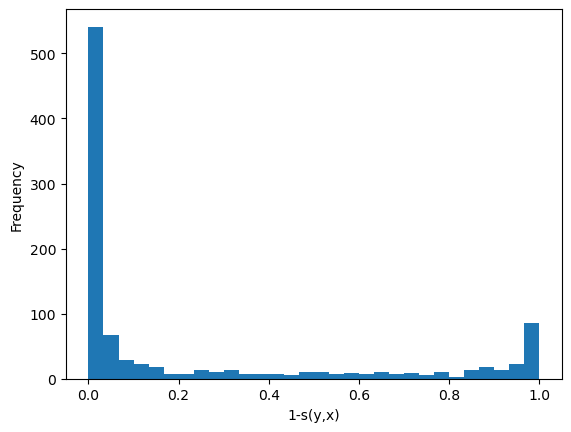

In [8]:
#matplotlib plot

#get the probabilities from the model
predictions=model.predict_proba(X_calib)
#get for each instance the actual probability of the ground truth
prob_for_true_class = predictions[np.arange(len(y_calib)),y_calib]
plt.hist(1-prob_for_true_class,bins=30,range=(0,1))
plt.xlabel("1-s(y,x)")
plt.ylabel("Frequency")
plt.show()

In [13]:
predictions_sets= (1-model.predict_proba(X_new)<=qhat)
for i in range(3):
    print(le.classes_[predictions_sets[i]])

['HOROZ' 'SIRA']
['SIRA']
['BARBUNYA' 'CALI']


On average, the prediction sets cover the true class with a probability of 95%

# MAPIE
MAPIE is a python library for conformal prediction

In [18]:
from mapie.classification import MapieClassifier
cp= MapieClassifier(estimator= model,cv="prefit",method="score")
cp.fit(X_calib,y_calib)
y_pred,y_set=  cp.predict(X_new,alpha=0.05) #provide an array to alpha if you want to see the prediction sets for different values of alpha
print(np.shape(y_set))
y_set=np.squeeze(y_set)
print(np.shape(y_set))

(1611, 7, 1)
(1611, 7)


In [17]:
for i in range(5):
    print(le.classes_[y_set[i]])

['HOROZ' 'SIRA']
['SIRA']
['BARBUNYA' 'CALI']
['SEKER']
['BOMBAY']


In [22]:
#count number of classes per bean
set_sizes= y_set.sum(axis=1)
print(set_sizes)
#use pandas to compute how often each size occurs
print(pd.Series(set_sizes).value_counts())

[2 1 2 ... 3 2 1]
2    789
1    678
3    144
Name: count, dtype: int64


In [ ]:
#use a pandas dataframe to hold the results

